Augment the literature data

In [1]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, dw_gen
from modelval.ArbDataGen import arb_w_gen

import warnings
warnings.filterwarnings('ignore')

% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


In [93]:
# Generate data for STDP
data1 = data[data['ptl_idx']==1]
data1_gen, targets1 = dw_gen.STDP_dw_gen(n_neighbors=3)

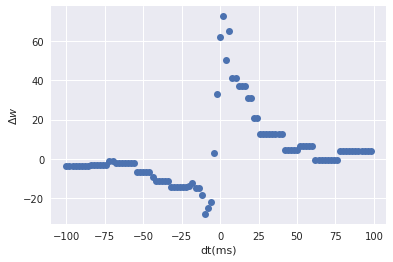

In [94]:
plt.plot(data1_gen['dt1'], targets1,'o')
plt.xlabel('dt(ms)')
plt.ylabel('$\Delta w$')

In [95]:
# Generate data for Triplet
dt = np.array([-10, -5, 0, 5, 10]).reshape(-1,1)
data2_gen, targets2 = dw_gen.triplet_dw_gen(dt)

[-110, 100, -30, 60]

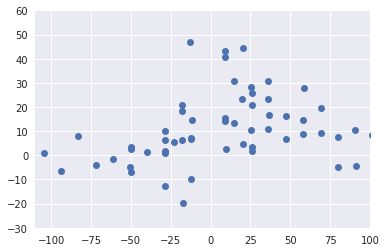

In [96]:
data3 = data[data['ptl_idx']==3]
X = np.array(data3['dt2']).reshape(-1,1)
y = np.array(data3['dw_mean']).reshape(-1,1)
plt.plot(data3['dt2'], data3['dw_mean'], 'o')
plt.axis([-110, 100, -30, 60])

In [97]:
np.abs(data3['dt2']).min()

9.1519535919999999

In [98]:
# Generate dt1
# Insert values for Quadruplet
dt = np.concatenate([np.arange(-100,-9,2).reshape(-1,1), np.arange(9,100,2).reshape(-1,1)])
data3_gen = pd.DataFrame(data=None, columns=list(data.columns))
for i in range(len(dt)):
    new_try3 = data3.iloc[0]
    new_try3['dt2'] = dt[i]
    data3_gen = data3_gen.append(new_try3, ignore_index=True)

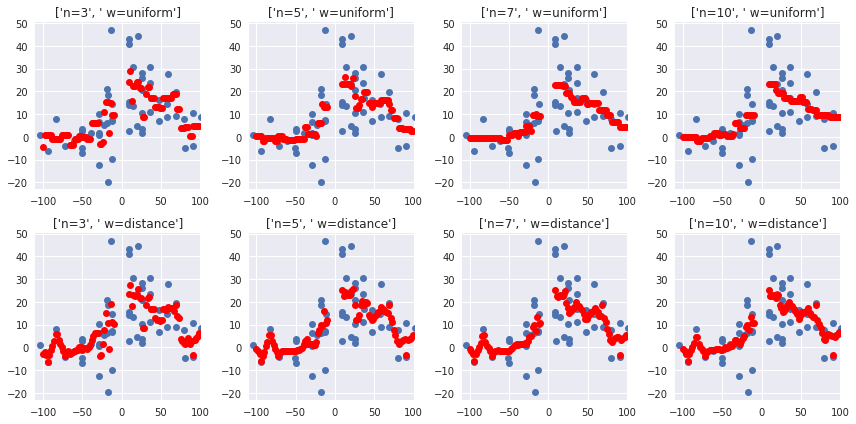

In [99]:
# Use K nearest neigbors to estimate the mean value of a given dt1
from sklearn.neighbors import KNeighborsRegressor

# Search through the parameter for the one gives the minimum reconstruction error
n_neighbors = [3,5,7,10]
weights = ['uniform', 'distance']

figure, ax = plt.subplots(2,4)
figure.set_figheight(6)
figure.set_figwidth(12)

for j in range(len(weights)):
    for i in range(len(n_neighbors)):
        
        Kn_reg = KNeighborsRegressor(n_neighbors=n_neighbors[i], weights=weights[j])
        Kn_reg.fit(X,y)
        y_pred = Kn_reg.predict(np.array(data3_gen['dt2']).reshape(-1,1))
        
        # Calculate mean squared error
        
        ax[j,i].plot(data3['dt2'], data3['dw_mean'], 'o')
        ax[j,i].plot(data3_gen['dt2'], y_pred, 'ro')
        ax[j,i].set_xlim([-110,100])
        ax[j,i].set_title(['n=%d'%(n_neighbors[i]), ' w=%s'%(weights[j])])
plt.tight_layout()

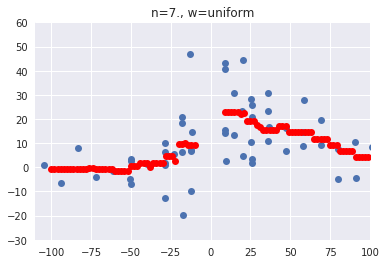

In [100]:
# Choose one parameter and generate the prediction
n_neighbors = 7
weights = 'uniform'

Kn_reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
Kn_reg.fit(X,y)
y_pred = Kn_reg.predict(np.array(data3_gen['dt2']).reshape(-1,1))
targets3=y_pred
plt.plot(data3['dt2'], data3['dw_mean'], 'o')
plt.plot(data3_gen['dt2'], y_pred, 'ro')
plt.axis([-110,100,-30,60])
plt.title('.'.join(('n=%d'%(n_neighbors), ', w=%s'%(weights))))

In [101]:
trip_para = pd.read_pickle('/src/Plasticity_Ker/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

1.0 1.0


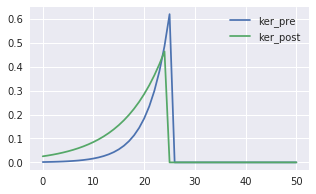

In [102]:
# Visualize kernel
from modelval.kernel import KernelGen
plt.figure(figsize=(5,3))
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms

ker_test = KernelGen()
ker_test.trip_model_ker(para, data_name='Hippocampus')
plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
plt.legend()
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2))

In [103]:
data_gen = pd.concat([data1_gen, data3_gen])
targets = np.concatenate([targets1, targets3])

([<matplotlib.lines.Line2D at 0x7f7e7300ec50>],)

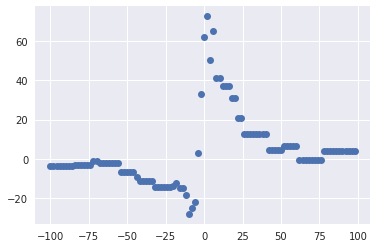

In [104]:
plt.plot(data_gen.iloc[:len(data1_gen)]['dt1'],targets[:targets1.shape[0]],'o'), 

([<matplotlib.lines.Line2D at 0x7f7e72dc2748>],)

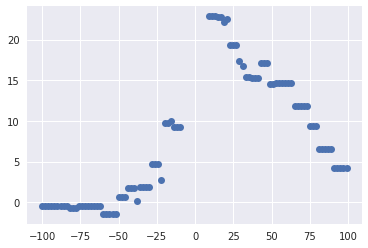

In [105]:
plt.plot(data_gen.iloc[len(data1_gen):]['dt2'],targets[targets1.shape[0]:],'o'), 

In [106]:
ptl_list = [1,3]
spk_len = int(data3_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data_gen, ptl_list=ptl_list, targets=targets, spk_len=spk_len, kernel=ker_test, aug_times=[20,20])

In [107]:
# # np.save('/src/Plasticity_Ker/data/spk_pairs.npy', spk_pairs)
# # np.save('/src/Plasticity_Ker/data/targets.npy', targets)
# spk_pairs = np.load('/src/Plasticity_Ker/data/spk_pairs.npy')
# targets = np.load('/src/Plasticity_Ker/data/targets.npy')

In [108]:
targets.shape

(3840, 1)

In [112]:
# Create the network
ground_truth_init = 0
toy_data_net = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, n_input=spk_pairs.shape[1])

In [113]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/Trip_ptl1_3_real_aug'
toy_net_trainer = trainer.Trainer(toy_data_net.loss, toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

In [114]:
# Obtain the training and validation data
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(spk_pairs, targets, test_size=0.1)
X_train, X_vali, y_train, y_vali = train_test_split(X_train_val,  y_train_val, test_size=0.1)
train_data = dataset.Dataset(X_train, y_train)
vali_data = dataset.Dataset(X_vali, y_vali)

array([-0.22614121, -0.27994752], dtype=float32)

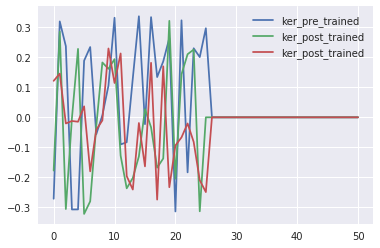

In [115]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
plt.plot(w_pre,  label='ker_pre_trained')
plt.plot(w_post,  label='ker_post_trained')
plt.plot(w_post_post,  label='ker_post_trained')
plt.legend()
fc_w[:2]

In [116]:
# # Learn the kernel from random initialization
# learning_rate = 0.001/9
# iterations = 5
# min_error = -1
# for i in range(iterations):
#     toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
#     learning_rate = learning_rate/3

array([-0.98985314, -0.9941597 ,  1.35988843], dtype=float32)

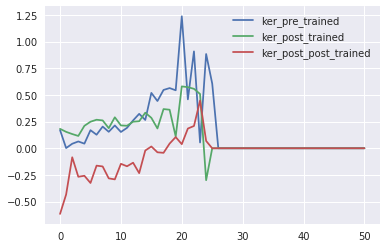

In [117]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
plt.plot(-1* w_pre, label='ker_pre_trained')
plt.plot(-1* w_post, label='ker_post_trained')
plt.plot(w_post_post, label='ker_post_post_trained')
plt.legend()
fc_w

In [118]:
# Compare the target and prediction

In [119]:
ker_test.kernel_pre = w_pre
ker_test.kernel_post = w_post
ker_test.kernel_post = w_post_post
ker_test.kernel_scale = fc_w

In [120]:
targets

array([[-3.78142352],
       [-3.78142352],
       [-3.78142352],
       ..., 
       [ 4.20231024],
       [ 4.20231024],
       [ 4.20231024]])

In [121]:
spk_len = int(data1_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, predictions = arb_w_gen(df=data3_gen, spk_pairs=spk_pairs, spk_len=spk_len, kernel=ker_test)

In [122]:
# np.save('/src/Plasticity_Ker/data/predictions.npy', predictions)
# predictions = np.load('/src/Plasticity_Ker/data/predictions.npy')

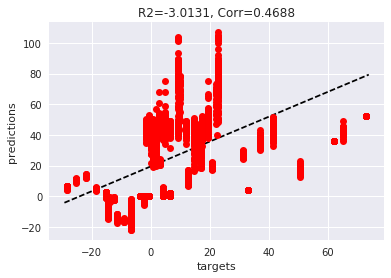

In [123]:
# Calculate R square
R2 = 1 - np.sum(np.square(predictions - targets))/np.sum(np.square(targets - np.mean(targets)))
# Calculate correlation coefficient
corr = np.sum(np.dot((predictions - np.mean(predictions)).T, targets - np.mean(targets)))/np.std(predictions)/np.std(targets)/len(targets)
b1 = np.sum(np.dot((predictions - np.mean(predictions)).T, targets - np.mean(targets)))/np.sum(np.square(targets - np.mean(targets)))
b2 = np.mean(predictions) - np.mean(targets)*b1
x_fit = np.linspace(np.min(targets)-1, np.max(targets)+1, 100)
y_fit = x_fit * b1 + b2
plt.plot(x_fit, y_fit, 'k--')
plt.plot(targets, predictions, 'ro')
plt.xlabel('targets')
plt.ylabel('predictions')
plt.title(''.join(('R2=%.4f'%(R2), ', Corr=%.4f'%(corr))))

Generate test restuls

In [ ]:
ptl_list = [1]
spk_len = int(data1_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, predictions = arb_w_gen(spk_pairs=X_test, df=data1_gen, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[20])

In [ ]:
targets = y_test

In [ ]:
# Calculate R square
R2 = 1 - np.sum(np.square(predictions - targets))/np.sum(np.square(targets - np.mean(targets)))
# Calculate correlation coefficient
corr = np.sum(np.dot((predictions - np.mean(predictions)).T, targets - np.mean(targets)))/np.std(predictions)/np.std(targets)/len(targets)
b1 = np.sum(np.dot((predictions - np.mean(predictions)).T, targets - np.mean(targets)))/np.sum(np.square(targets - np.mean(targets)))
b2 = np.mean(predictions) - np.mean(targets)*b1
x_fit = np.linspace(np.min(targets)-1, np.max(targets)+1, 100)
y_fit = x_fit * b1 + b2
plt.plot(x_fit, y_fit, 'k--')
plt.plot(targets, predictions, 'ro')
plt.xlabel('targets')
plt.ylabel('predictions')
plt.title(''.join(('R2=%.4f'%(R2), ', Corr=%.4f'%(corr))))